<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="https://raw.githubusercontent.com/DataForScience/Networks/master/data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0" width=150px> </div>
    <div style="float: left; margin-left: 10px;"> 
        <h1>Searching in Graphs</h1>
        <h1>Turn by turn directions</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
import warnings
warnings.filterwarnings('ignore')

from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import geopy
import geopy.distance

import networkx as nx
import osmnx as ox
ox.config(log_console=True)

import heapq

import watermark

%load_ext watermark
%matplotlib inline

We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 20.3.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

Git hash: d198e46e1a8d5c2c3886140239e777d69dc045c8

geopy     : 2.1.0
pandas    : 1.1.3
osmnx     : 1.0.1
networkx  : 2.5
matplotlib: 3.3.2
json      : 2.0.9
watermark : 2.1.0
numpy     : 1.19.2



Load default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Karate Club

In [4]:
G=nx.karate_club_graph()

In [5]:
np.random.seed(123)
layout = nx.layout.spring_layout(G)

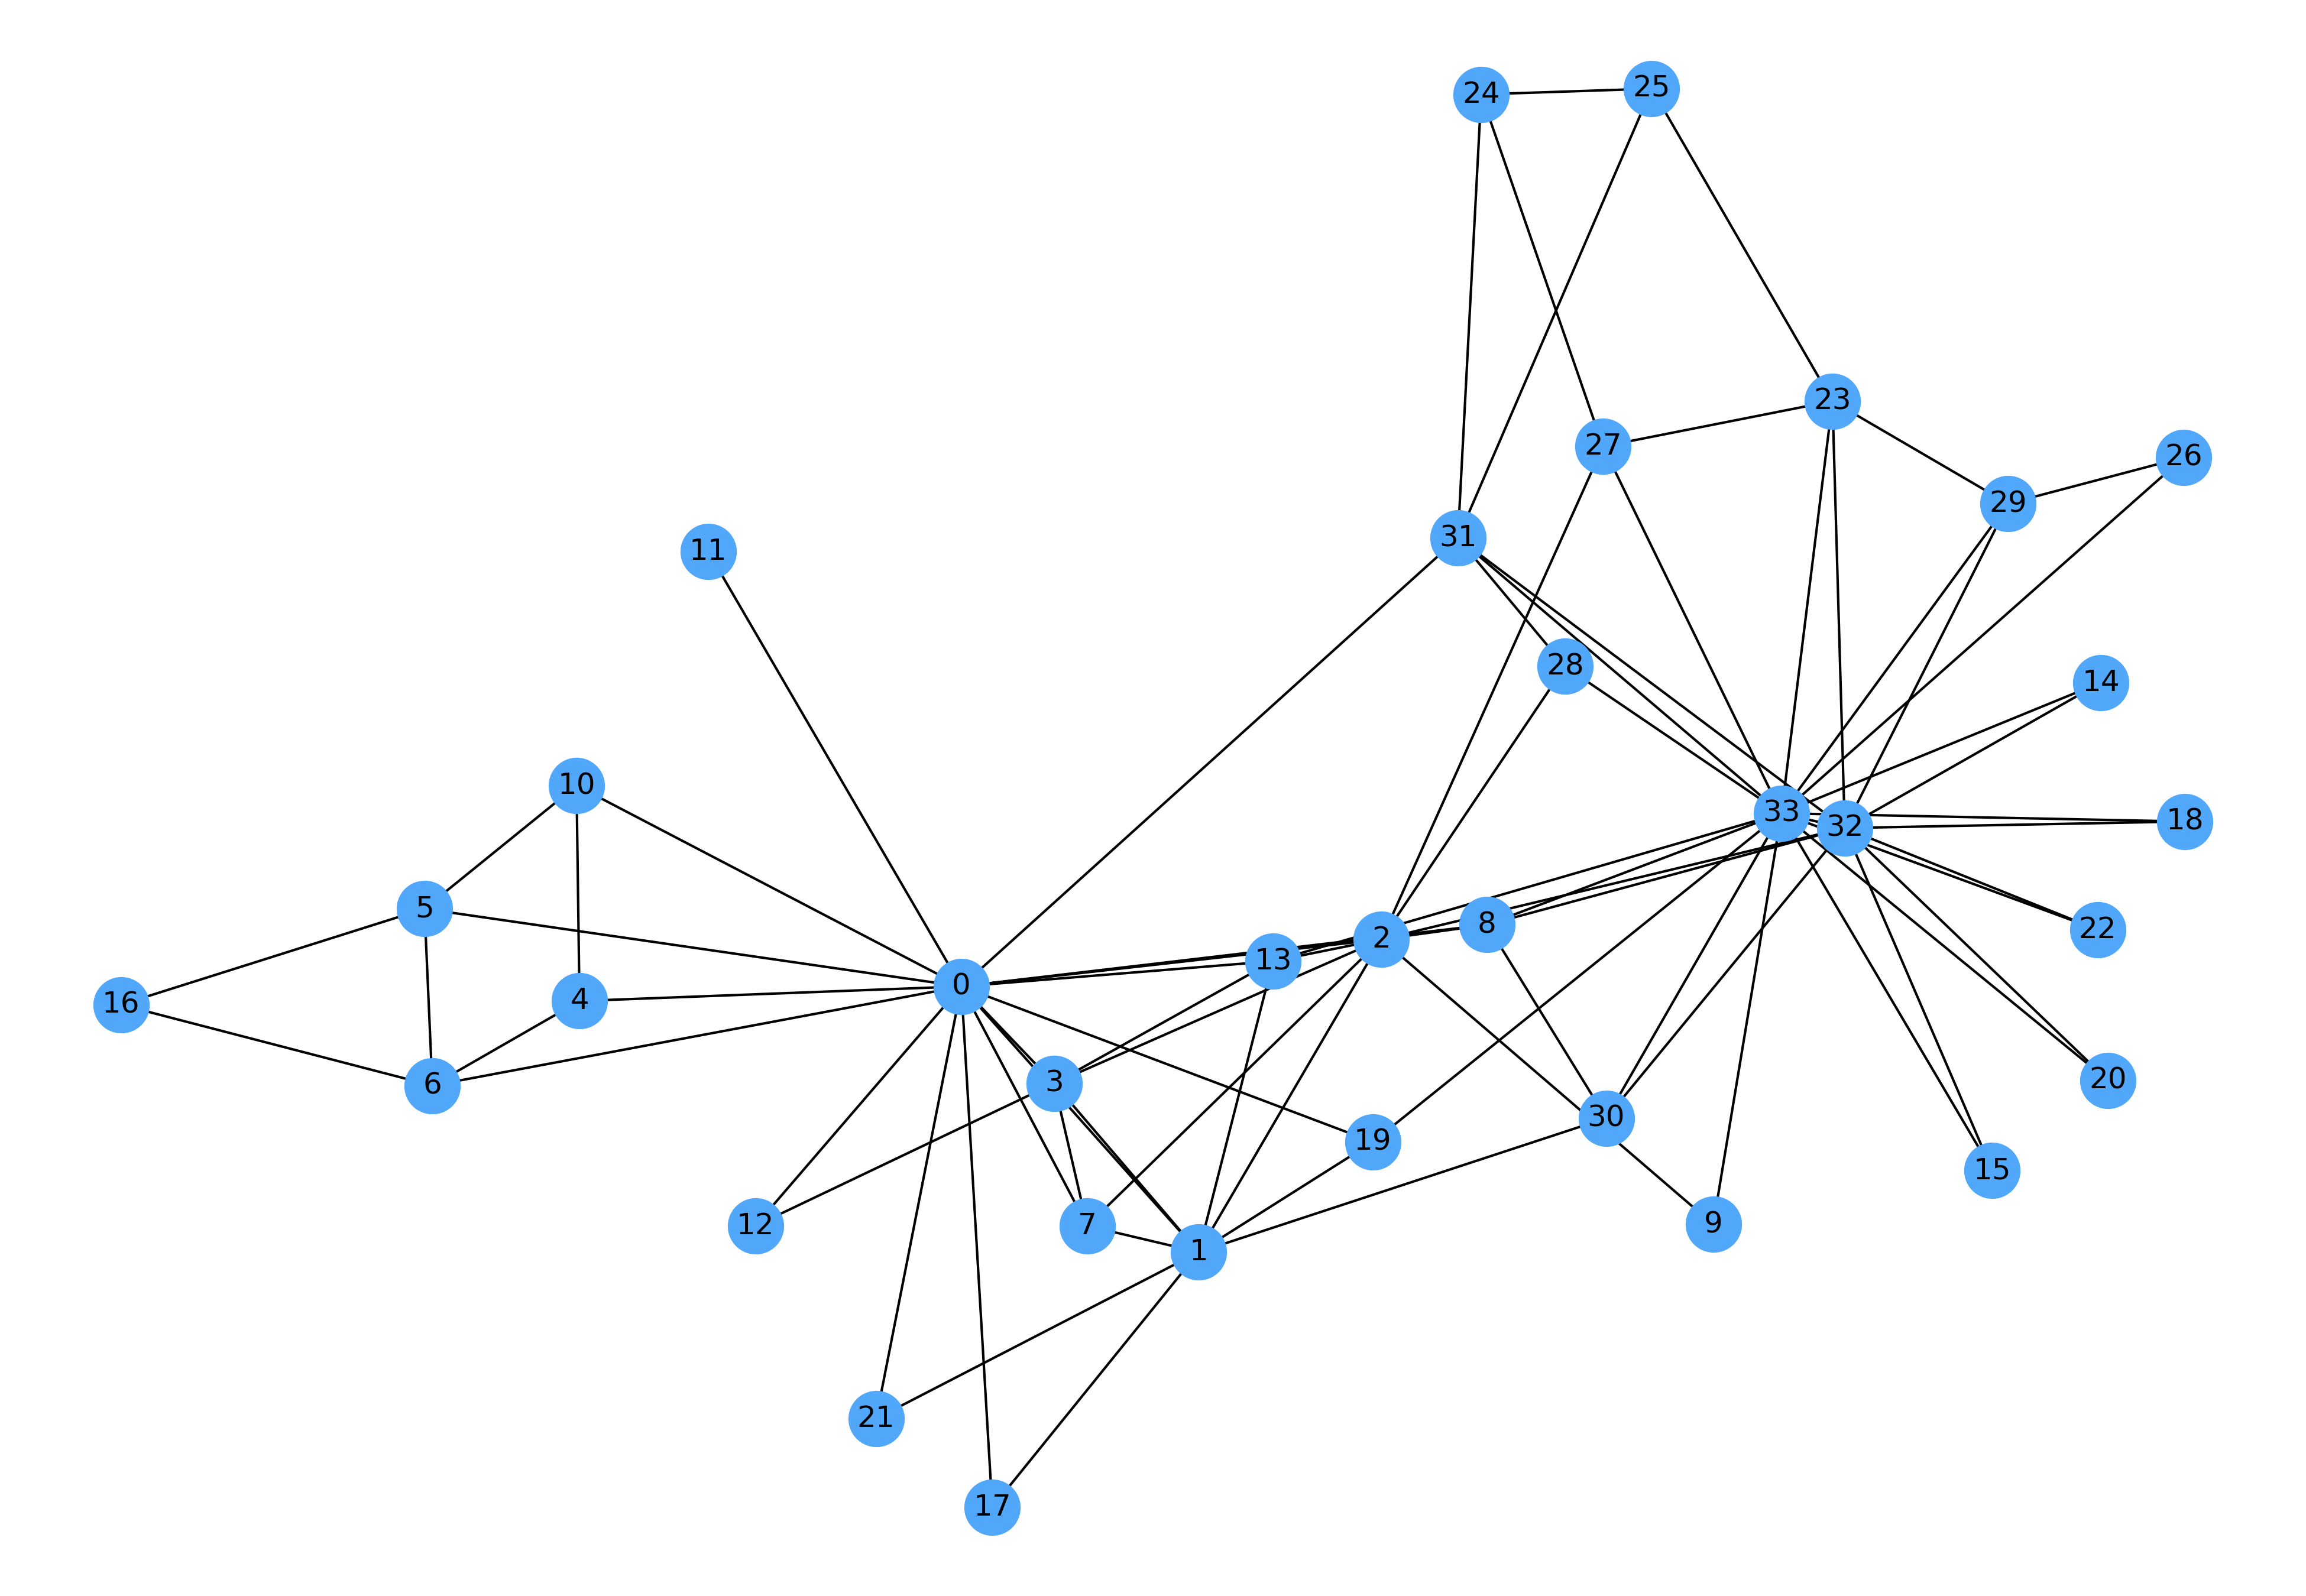

In [6]:
nx.draw(G, pos=layout, node_color=colors[0], node_size=500)
nx.draw_networkx_labels(G, pos=layout, font_color='k');

# Depth First Search

In [7]:
def DFS(G, root):
    G2 = G.copy()
    G2.nodes[root]['parent'] = root
    
    def DFS_worker(G, root, depth=0):
        G.nodes[root]['weight'] = depth

        for node in G[root]:
            if "weight" not in G.nodes[node]:
                G.nodes[node]['parent'] = root
                DFS_worker(G, node, depth+1)    
    
    DFS_worker(G2, root)

    dist = pd.DataFrame.from_dict(dict(G2.nodes(data=True)), 
                                  orient='index')[['weight', 'parent']]
    dist.index.name='node'
    
    return dist

In [8]:
DFS_dist = DFS(G, 2)

In [9]:
DFS_dist[DFS_dist['parent'] == 2]

weight  parent
node                
0          1       2
2          0       2

In [10]:
max_depth = DFS_dist['weight'].max()

In [11]:
max_depth

13

In [12]:
DFS_dist['color'] = DFS_dist['weight'].map(lambda x: plt.cm.tab20(x/(20)))

In [13]:
DFS_edges = DFS_dist.reset_index()[['parent', 'node']].values

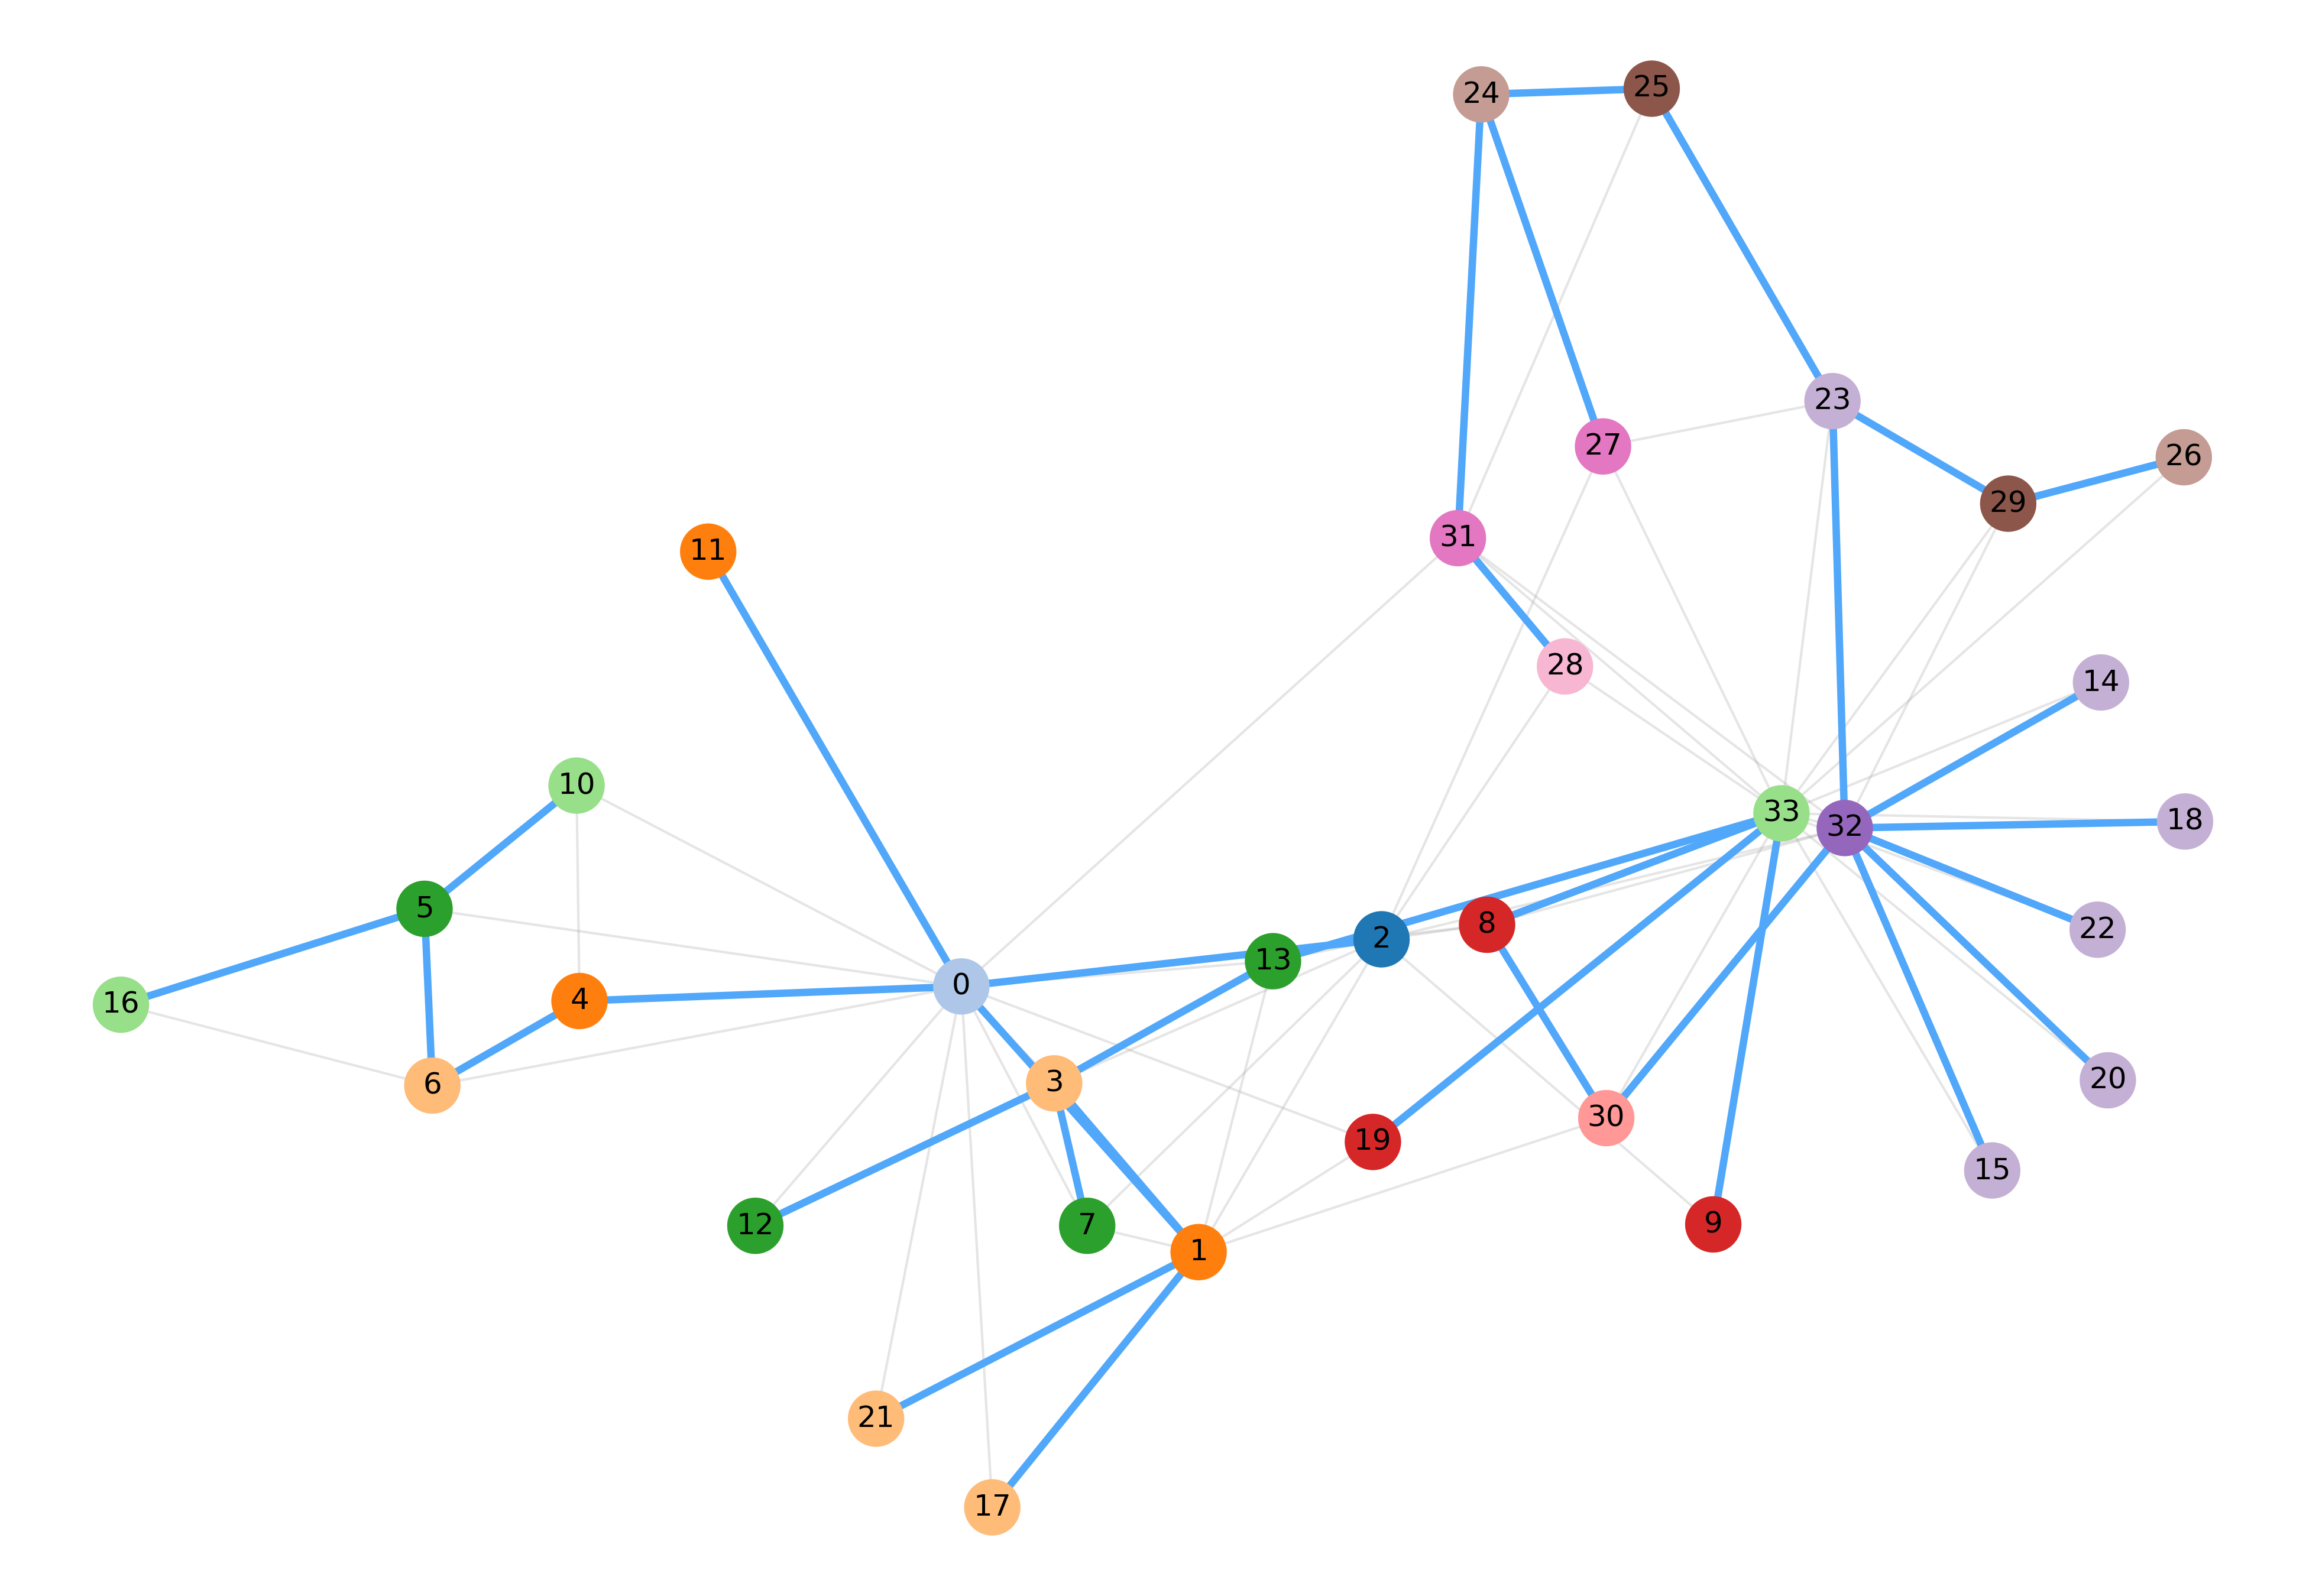

In [14]:
nx.draw(G, pos=layout, node_color=DFS_dist['color'].values, node_size=500, alpha=0.3, edge_color='darkgray')
nx.draw_networkx_nodes(G, pos=layout, node_color=DFS_dist['color'].values, node_size=500)
nx.draw_networkx_labels(G, pos=layout, font_color='k')
nx.draw_networkx_edges(G, pos=layout, edgelist=DFS_edges, width=3, edge_color=colors[0])

In [15]:
def get_path(dist, target):
    path = [target]

    while target != 2:
        target = dist.loc[target]['parent']
        path.append(target)
        
    return path[::-1]

In [16]:
path = get_path(DFS_dist, 28)

In [17]:
path

[2, 0, 1, 3, 13, 33, 8, 30, 32, 23, 25, 24, 31, 28]

In [18]:
short_edges = list(zip(path[:-1], path[1:]))

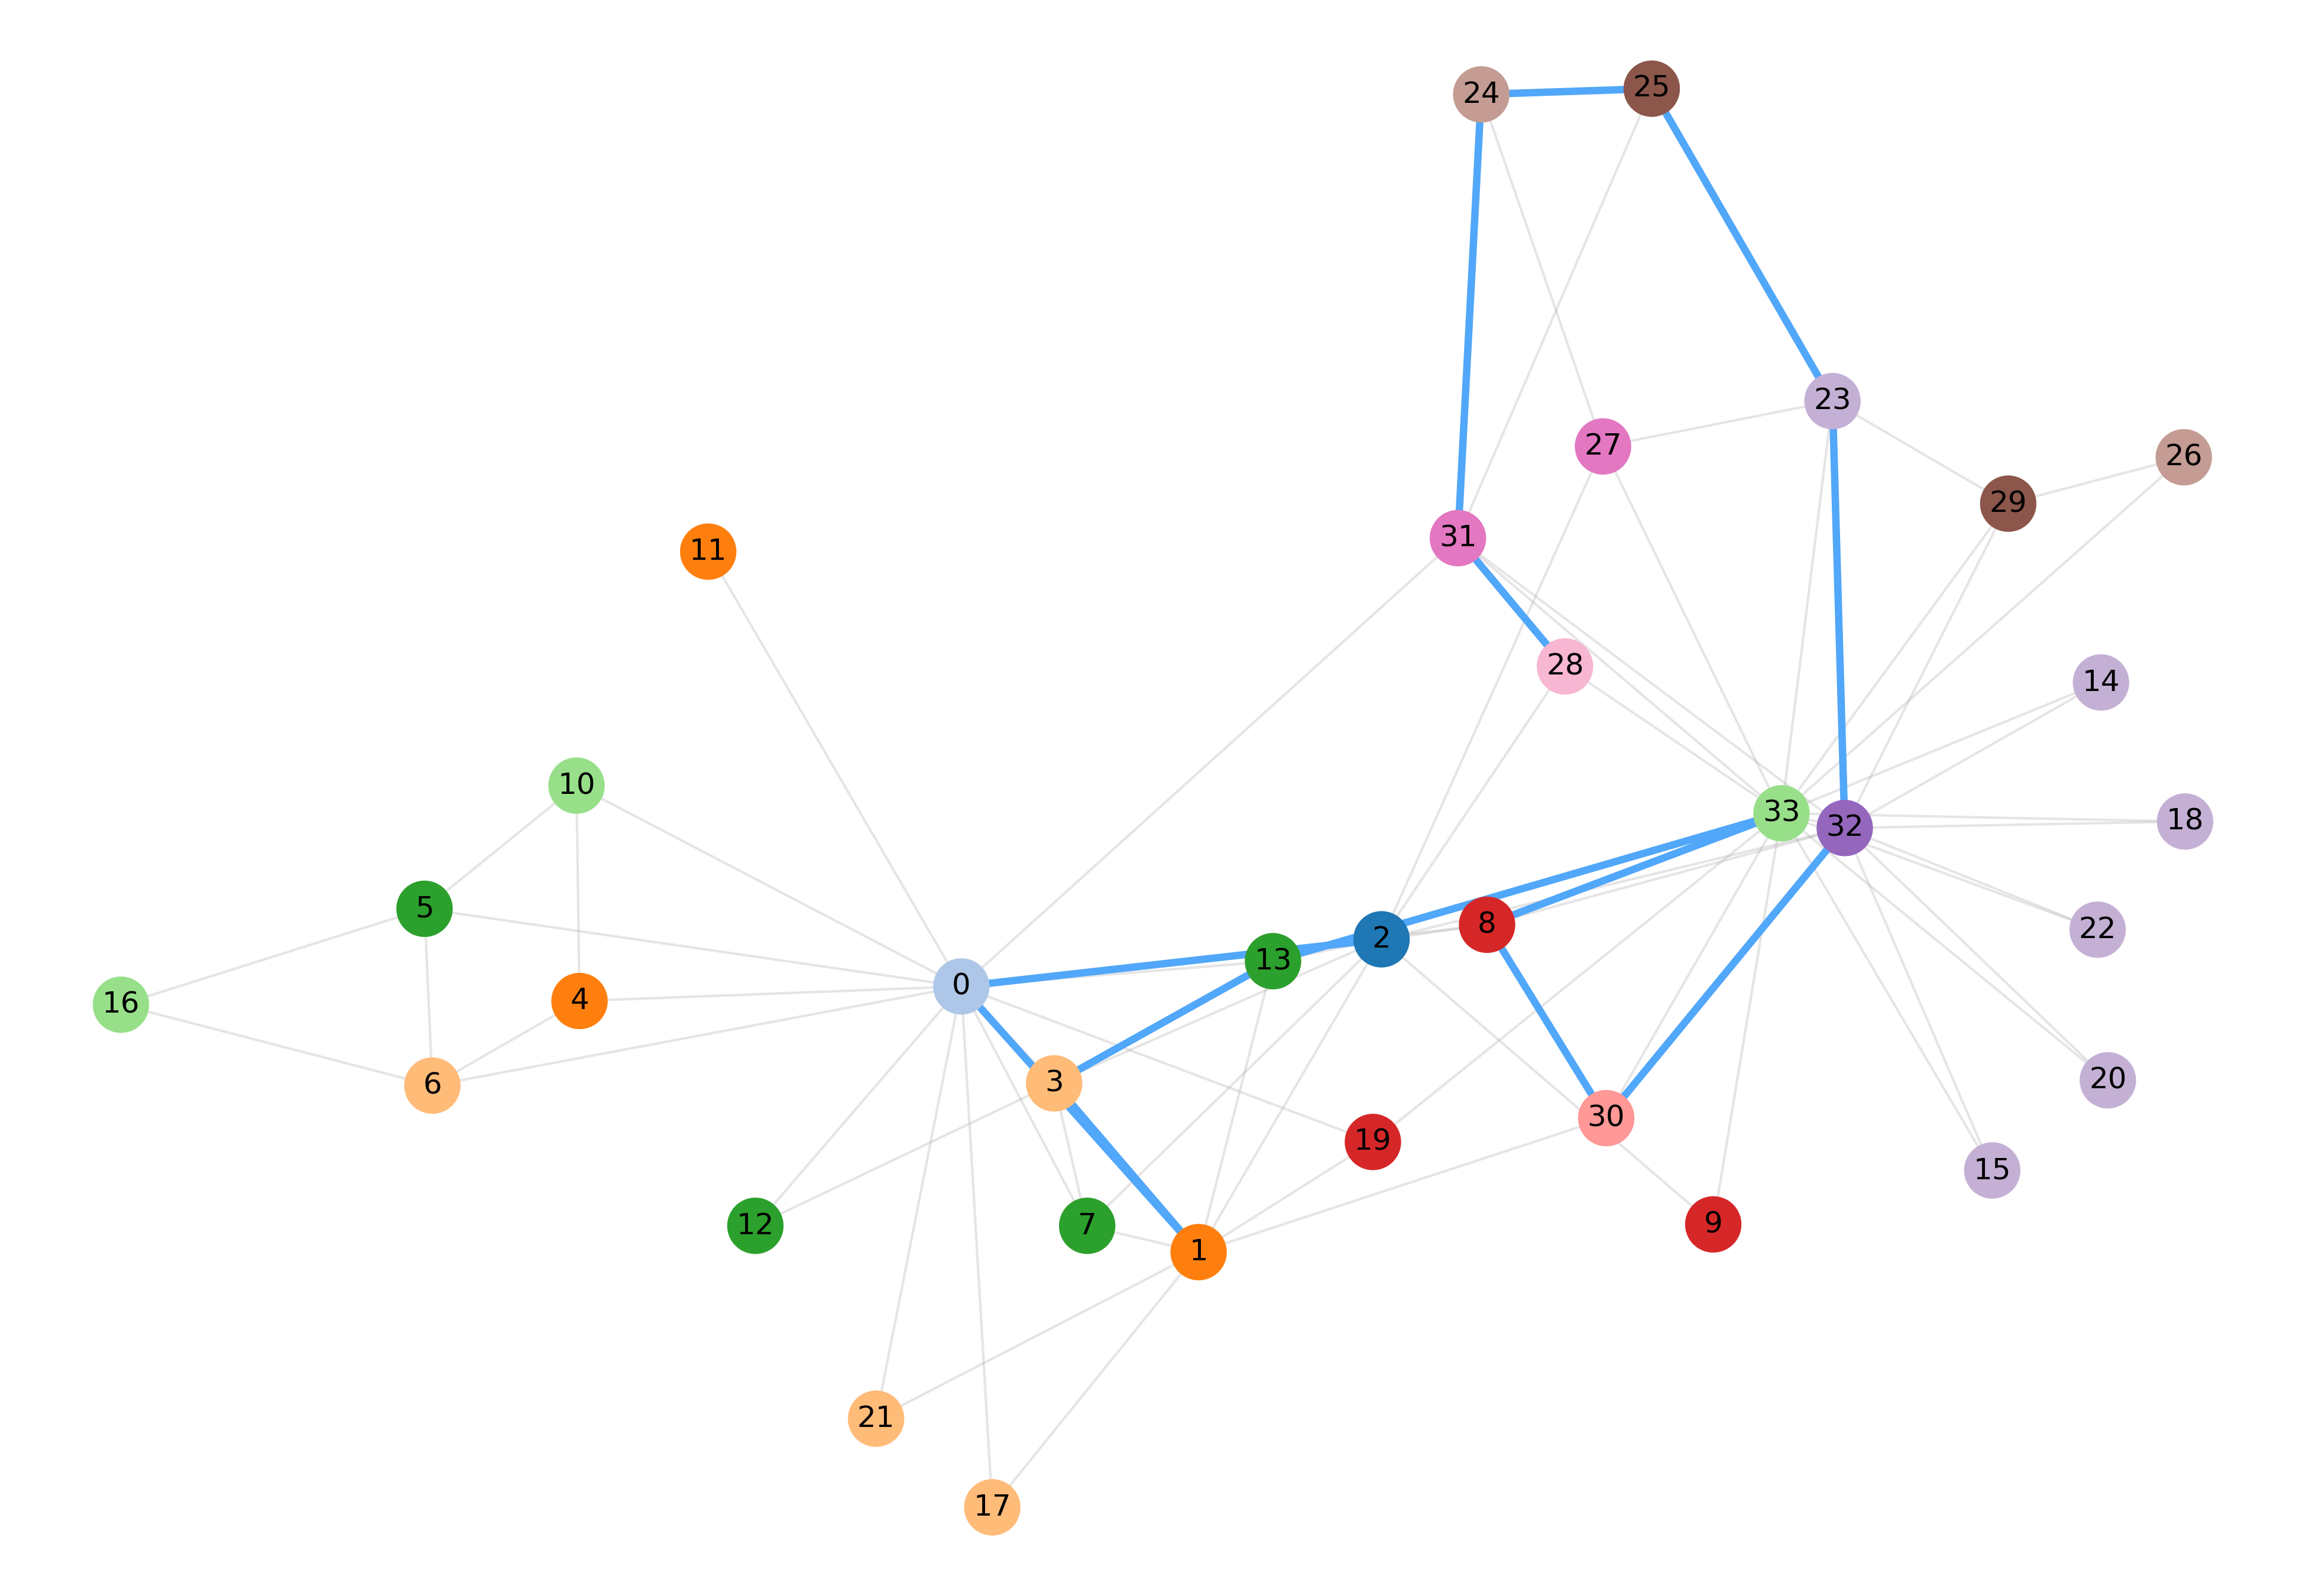

In [19]:
nx.draw(G, pos=layout, node_color=DFS_dist['color'].values, node_size=500, alpha=0.3, edge_color='darkgray')
nx.draw_networkx_nodes(G, pos=layout, node_color=DFS_dist['color'].values, node_size=500)
nx.draw_networkx_labels(G, pos=layout, font_color='k')
nx.draw_networkx_edges(G, pos=layout, edgelist=short_edges, width=3, edge_color=colors[0])

# Breath First Search

In [20]:
class PriorityQueue:
    def __init__(self):
        self.heap = []

    def push(self, node, priority):
        heapq.heappush(self.heap, [priority, node])

    def pop(self, data=True):
        if data:
            return heapq.heappop(self.heap)
        else:
            return heapq.heappop(self.heap)[1]

    def update(self, node, new_priority):
        pos = -1 

        for i, value in enumerate(self.heap):
            priority, node_i = value

            if node_i == node:
                self.heap[i][0] = new_priority
                pos = i
                break

        if pos == -1:
            self.heap.append([new_priority, node])

        heapq.heapify(self.heap)

    def empty(self):
        return len(self.heap) == 0

In [21]:
def BFS(G, root):
    queue = PriorityQueue()
    
    G2 = G.copy()
    depth = 0
    G2.nodes[root]['weight'] = depth
    queue.push((root, root), depth)
    
    while not queue.empty():
        depth, (node, parent) = queue.pop(True)
            
        G2.nodes[node]['weight'] = depth
        G2.nodes[node]['parent'] = parent
            
        for neighbour in G[node]:            
            if 'weight' not in G2.nodes[neighbour]:
                G2.nodes[neighbour]['weight'] = depth+1
                queue.push((neighbour, node), depth + 1)
    
    dist = pd.DataFrame.from_dict(dict(G2.nodes(data=True)), 
                                  orient='index')[['weight', 'parent']]
    dist.index.name='node'

    return dist

In [22]:
BFS_dist = BFS(G, 2)

In [23]:
BFS_dist[BFS_dist['parent'] == 2]

weight  parent
node                
0          1       2
1          1       2
2          0       2
3          1       2
7          1       2
8          1       2
9          1       2
13         1       2
27         1       2
28         1       2
32         1       2

In [24]:
max_depth = BFS_dist['weight'].max()

In [25]:
BFS_dist['color'] = BFS_dist['weight'].map(lambda x: plt.cm.tab20(x/20))

In [26]:
BFS_edges = BFS_dist.reset_index()[['parent', 'node']].values

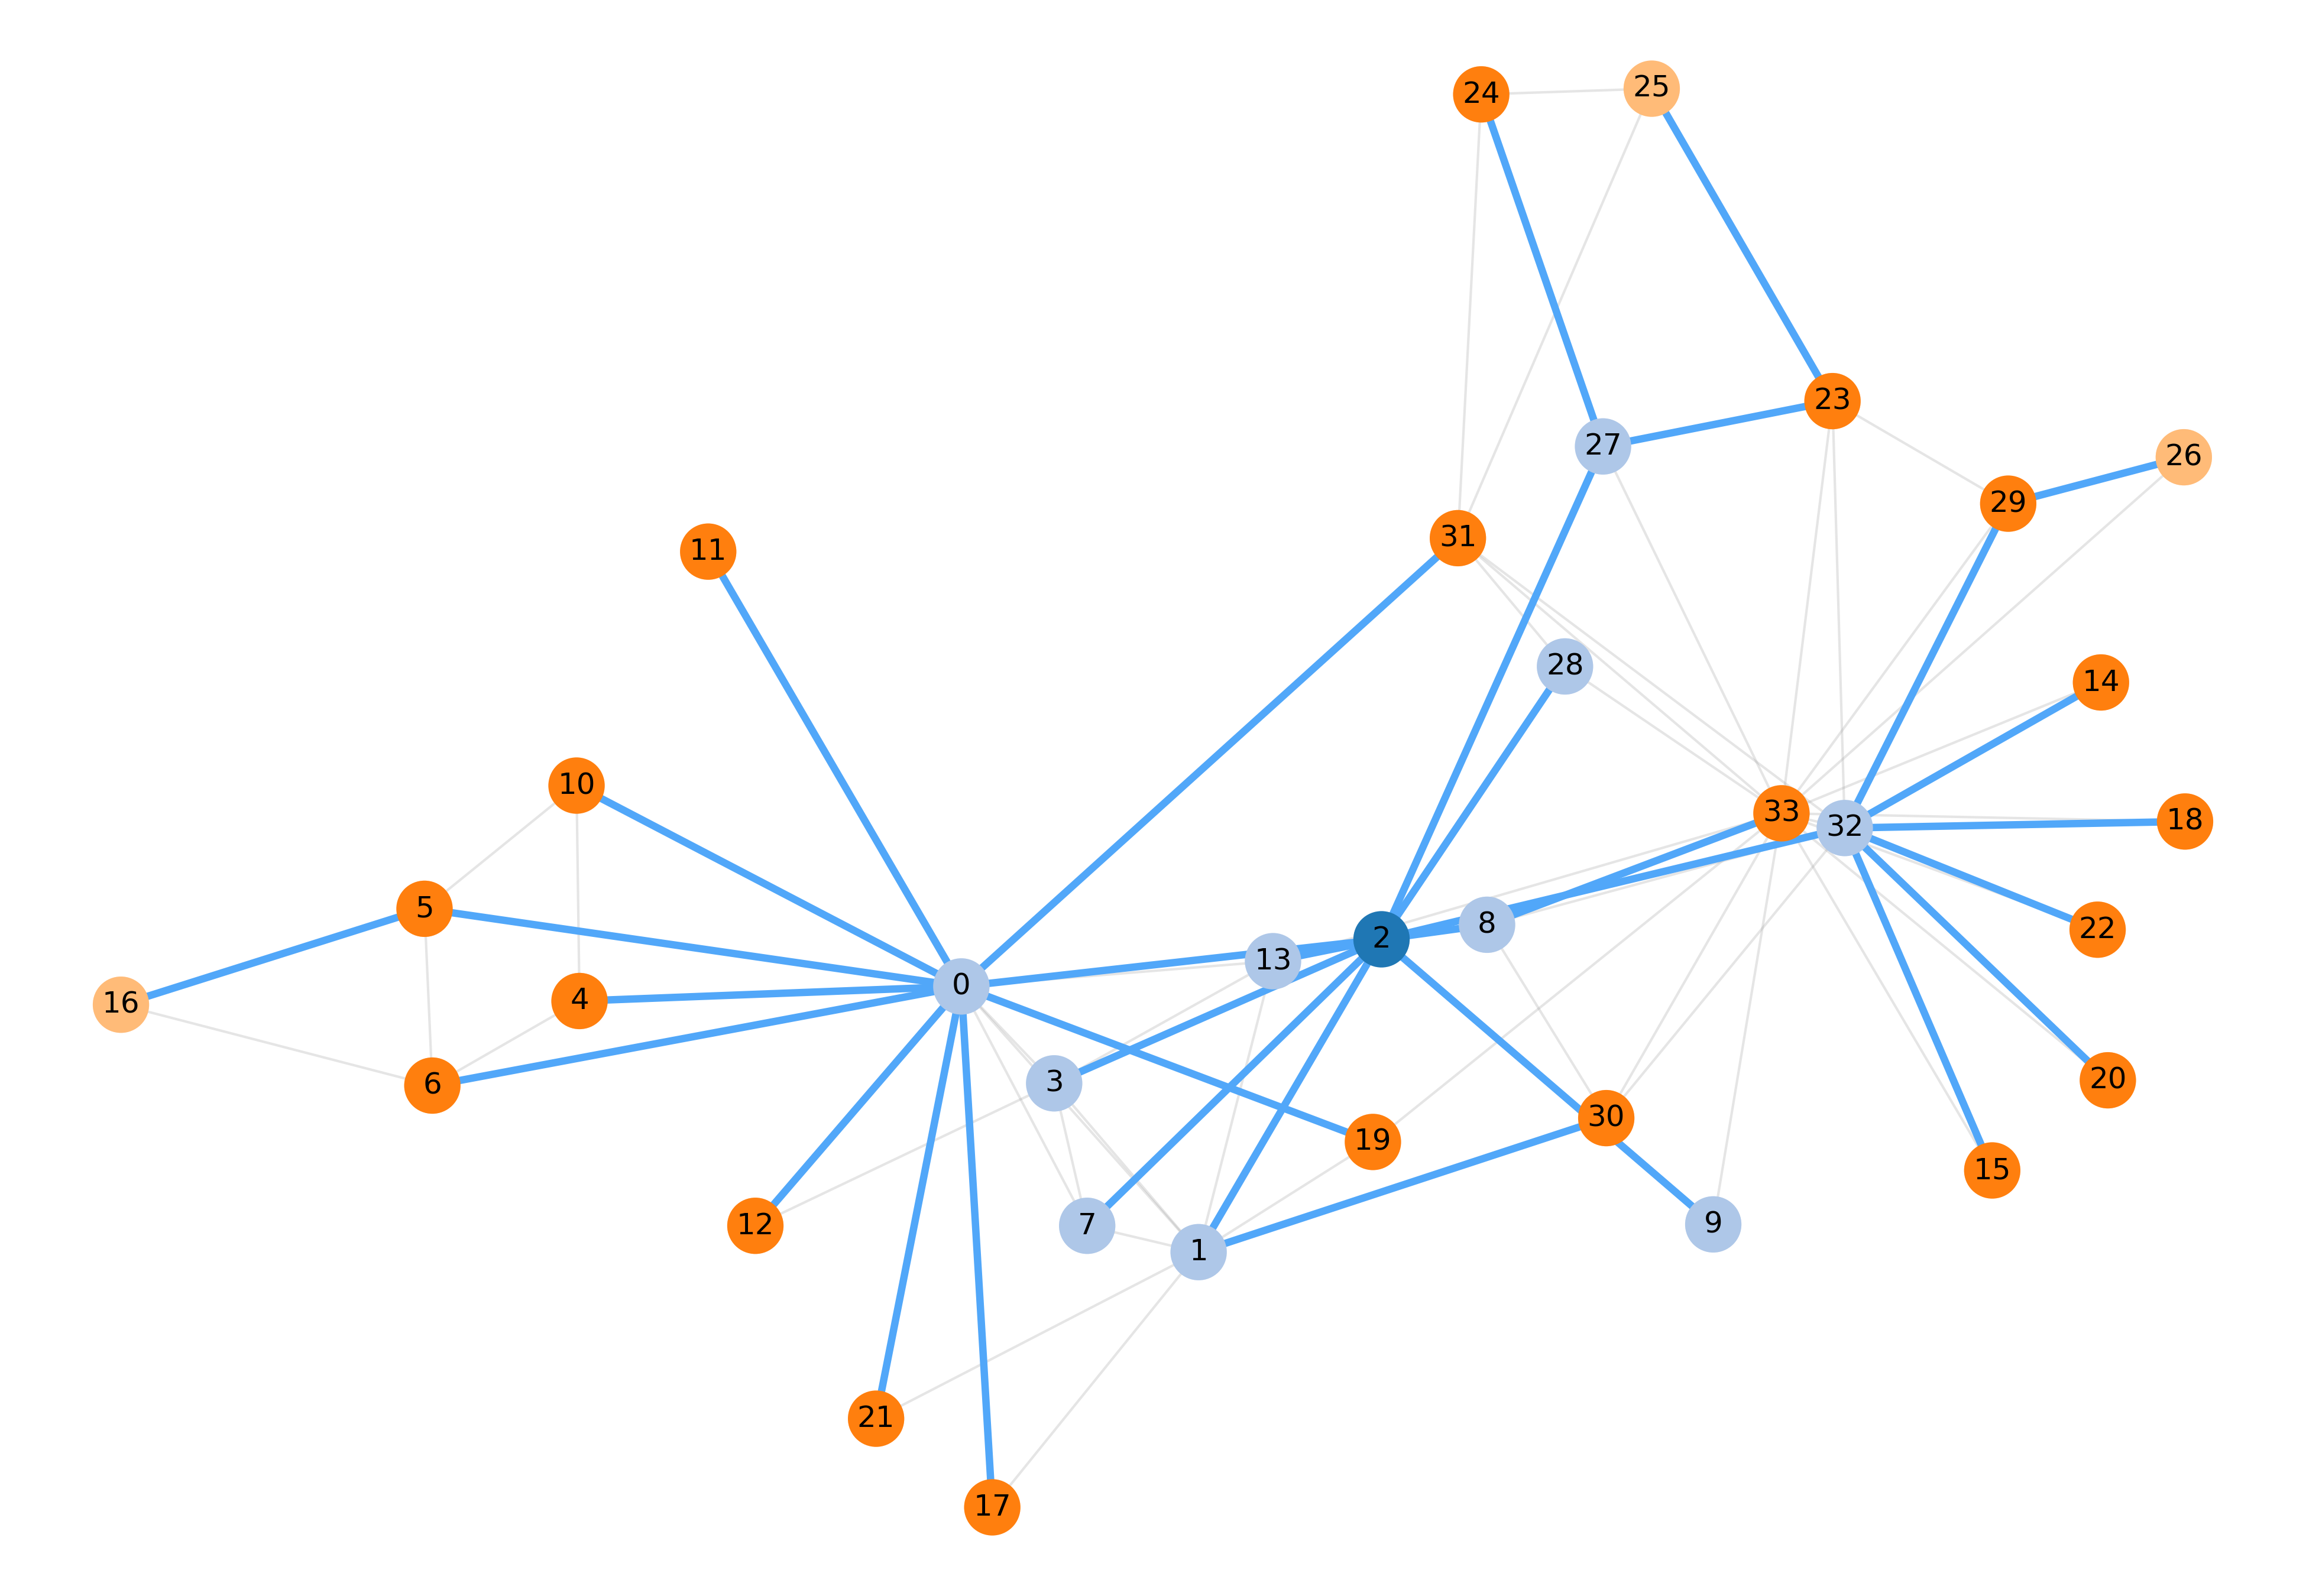

In [27]:
nx.draw(G, pos=layout, node_color=BFS_dist['color'].values, node_size=500, alpha=0.3, edge_color='darkgray')
nx.draw_networkx_nodes(G, pos=layout, node_color=BFS_dist['color'].values, node_size=500)
nx.draw_networkx_labels(G, pos=layout, font_color='k')
nx.draw_networkx_edges(G, pos=layout, edgelist=BFS_edges, width=3, edge_color=colors[0])

# Dijkstra Algorithm

In [28]:
for node_i, node_j in G.edges:
    G[node_i][node_j]['length'] = np.linalg.norm(layout[node_i] - layout[node_j])

In [29]:
def dijkstra(G, source, weight='length'):
    G2 = G.copy()
    
    queue = PriorityQueue()

    for node in G2.nodes:
        G2.nodes[node]['weight'] = np.inf
        G2.nodes[node]['parent'] = None
    
    G2.nodes[source]['weight'] = 0
    G2.nodes[source]['parent'] = source

    queue.push(source, 0)

    while not queue.empty():
        node_i = queue.pop(False)

        NN = G.neighbors(node_i)

        for node_j in NN:
            length = G[node_i][node_j][weight]
            new_dist = G2.nodes[node_i]['weight'] + length
            
            if new_dist < G2.nodes[node_j]['weight']:
                G2.nodes[node_j]['weight'] = new_dist
                G2.nodes[node_j]['parent'] = node_i

                queue.update(node_j, new_dist)
    
    dist = pd.DataFrame.from_dict(dict(G2.nodes(data=True)), 
                                  orient='index')[['weight', 'parent']]
    dist.index.name='node'

    return dist

In [30]:
dijkstra_dist = dijkstra(G, 2)

In [31]:
dijkstra_dist[dijkstra_dist['parent']==2]

weight  parent
node                  
0     0.338471       2
1     0.250894       2
2     0.000000       2
3     0.278848       2
7     0.300827       2
8     0.085192       2
9     0.324377       2
13    0.088214       2
27    0.366577       2
28    0.230592       2
32    0.378598       2

In [32]:
max_depth = dijkstra_dist['weight'].max()

In [33]:
dijkstra_dist['color'] = dijkstra_dist['weight'].map(lambda x: plt.cm.tab20(x/(max_depth)))

In [34]:
dijkstra_edges = dijkstra_dist.reset_index()[['parent', 'node']].values

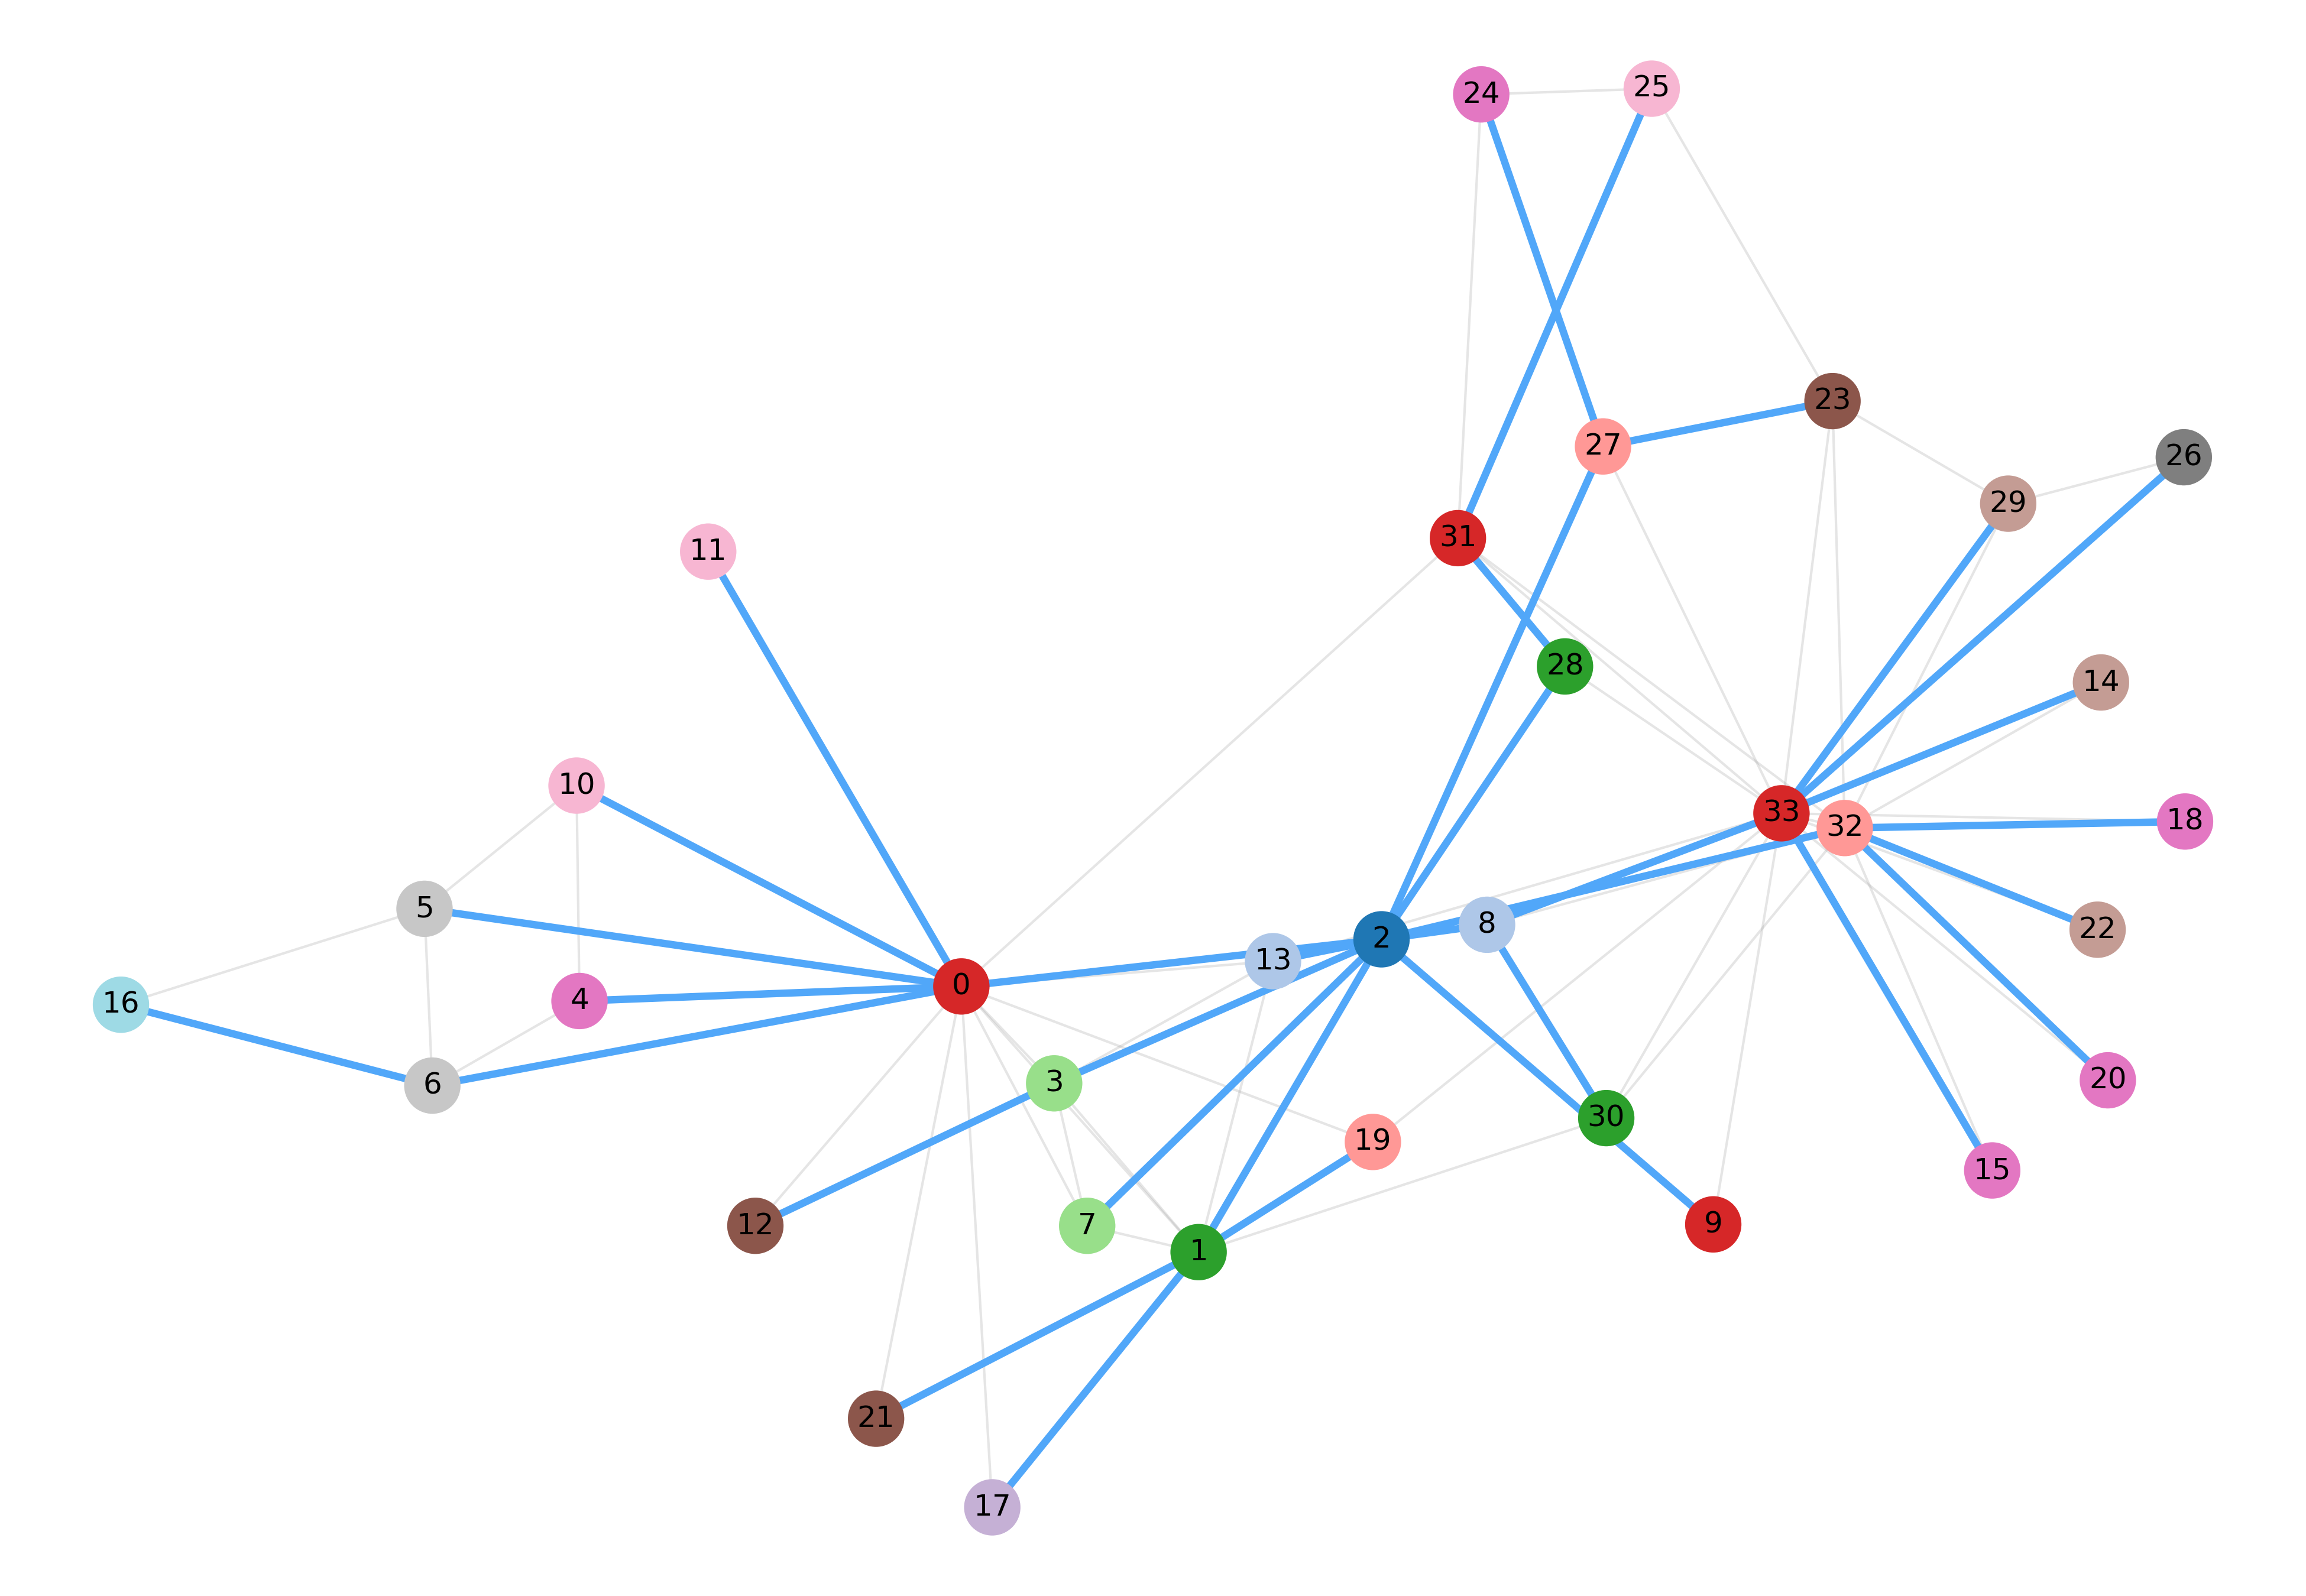

In [35]:
nx.draw(G, pos=layout, node_color=dijkstra_dist['color'].values, node_size=500, alpha=0.3, edge_color='darkgray')
nx.draw_networkx_nodes(G, pos=layout, node_color=dijkstra_dist['color'].values, node_size=500)
nx.draw_networkx_labels(G, pos=layout, font_color='k')
nx.draw_networkx_edges(G, pos=layout, edgelist=dijkstra_edges, width=3, edge_color=colors[0])

# Shortest Path

Both the Breath First Search and Dijkstra's algorithm can provide us with the shortest path between our source node and any other node we choose. For example, to obtain the shortest path between nodes 2 and 16

In [36]:
BFS_path = get_path(BFS_dist, 16)
dijkstra_path = get_path(dijkstra_dist, 16)

In [37]:
BFS_shortest_edges = list(zip(BFS_path[:-1], BFS_path[1:]))
dijkstra_shortest_edges = list(zip(dijkstra_path[:-1], dijkstra_path[1:]))

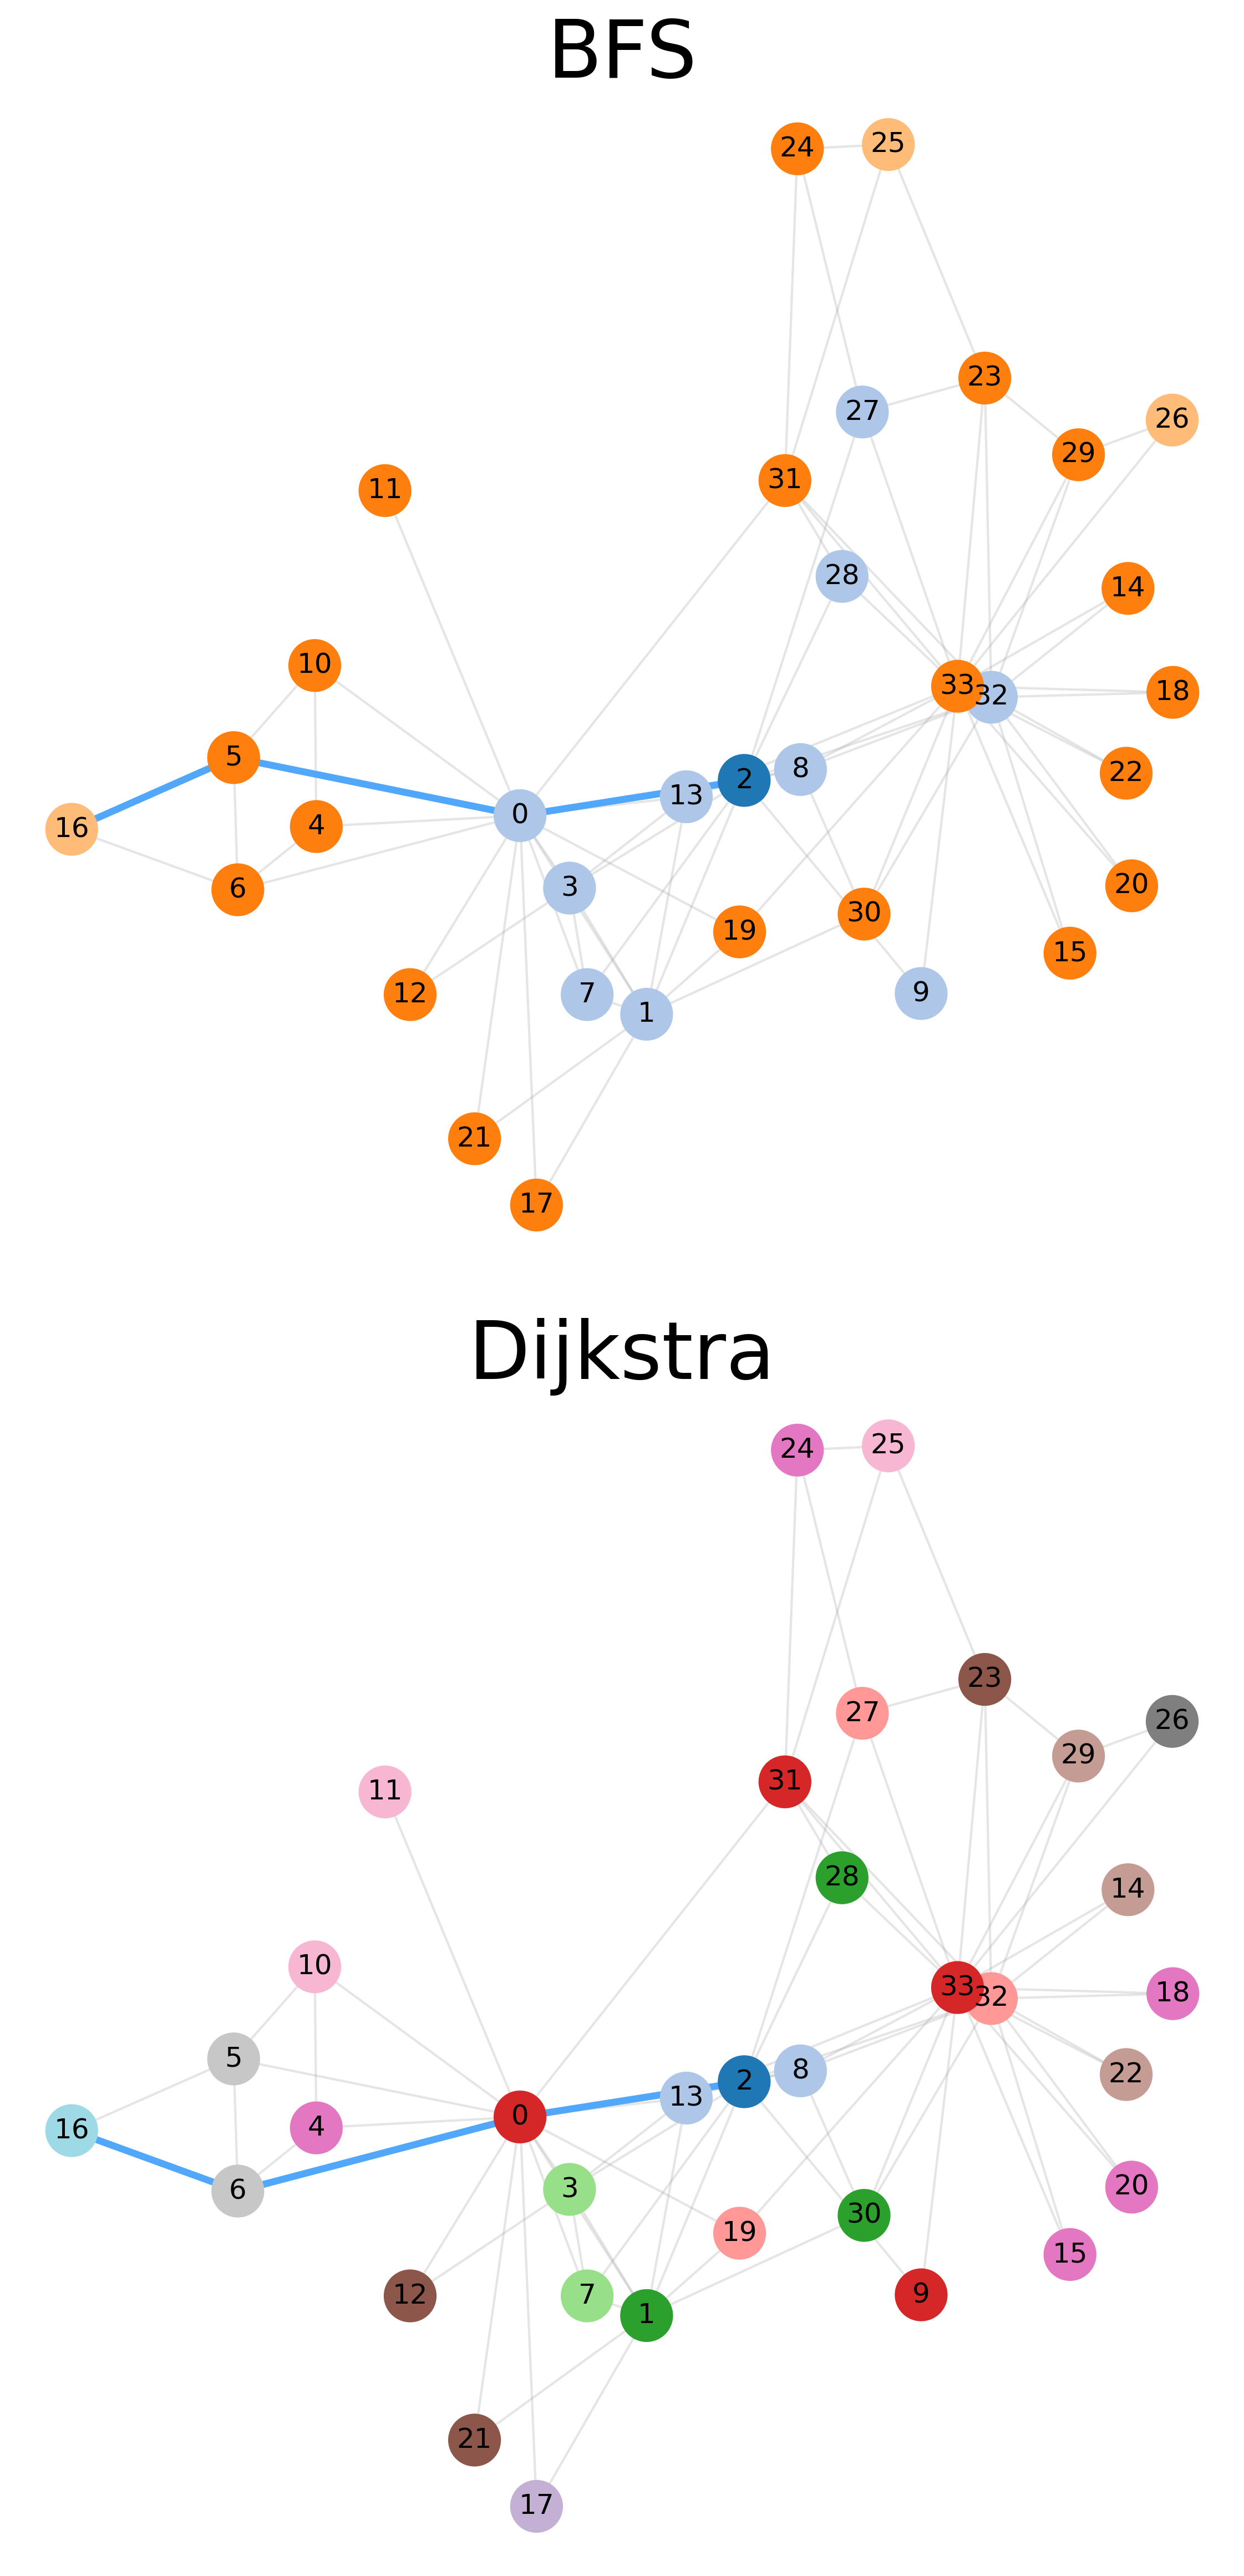

In [38]:
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(8, 16))

ax.set_title('BFS')
nx.draw(G, ax=ax, pos=layout, node_color=BFS_dist['color'].values, node_size=300, alpha=0.3, edge_color='darkgray')
nx.draw_networkx_nodes(G, ax=ax, pos=layout, node_color=BFS_dist['color'].values, node_size=500)
nx.draw_networkx_labels(G, ax=ax, pos=layout, font_color='k')
nx.draw_networkx_edges(G, ax=ax, pos=layout, edgelist=BFS_shortest_edges, width=3, edge_color=colors[0])

ax2.set_title('Dijkstra')
nx.draw(G, ax=ax2, pos=layout, node_color=dijkstra_dist['color'].values, node_size=300, alpha=0.3, edge_color='darkgray')
nx.draw_networkx_nodes(G, ax=ax2, pos=layout, node_color=dijkstra_dist['color'].values, node_size=500)
nx.draw_networkx_labels(G, ax=ax2, pos=layout, font_color='k')
nx.draw_networkx_edges(G, ax=ax2, pos=layout, edgelist=dijkstra_shortest_edges, width=3, edge_color=colors[0])

# Download Manhattan street map

We start by downloading the street map for the island of Manhattan. Here each node is an intersection and each edge a road. Depending on your internet connection, this might take a few seconds

In [39]:
place = 'Manhattan, NY, USA'
G_roads = ox.graph_from_place(place, network_type='drive')

In total we have over 4500 nodes and almost 10,000 edges

In [40]:
print("nodes:", G_roads.number_of_nodes())
print("edges:", G_roads.number_of_edges())

nodes: 4586
edges: 9885


Which we can plot in a familiar form

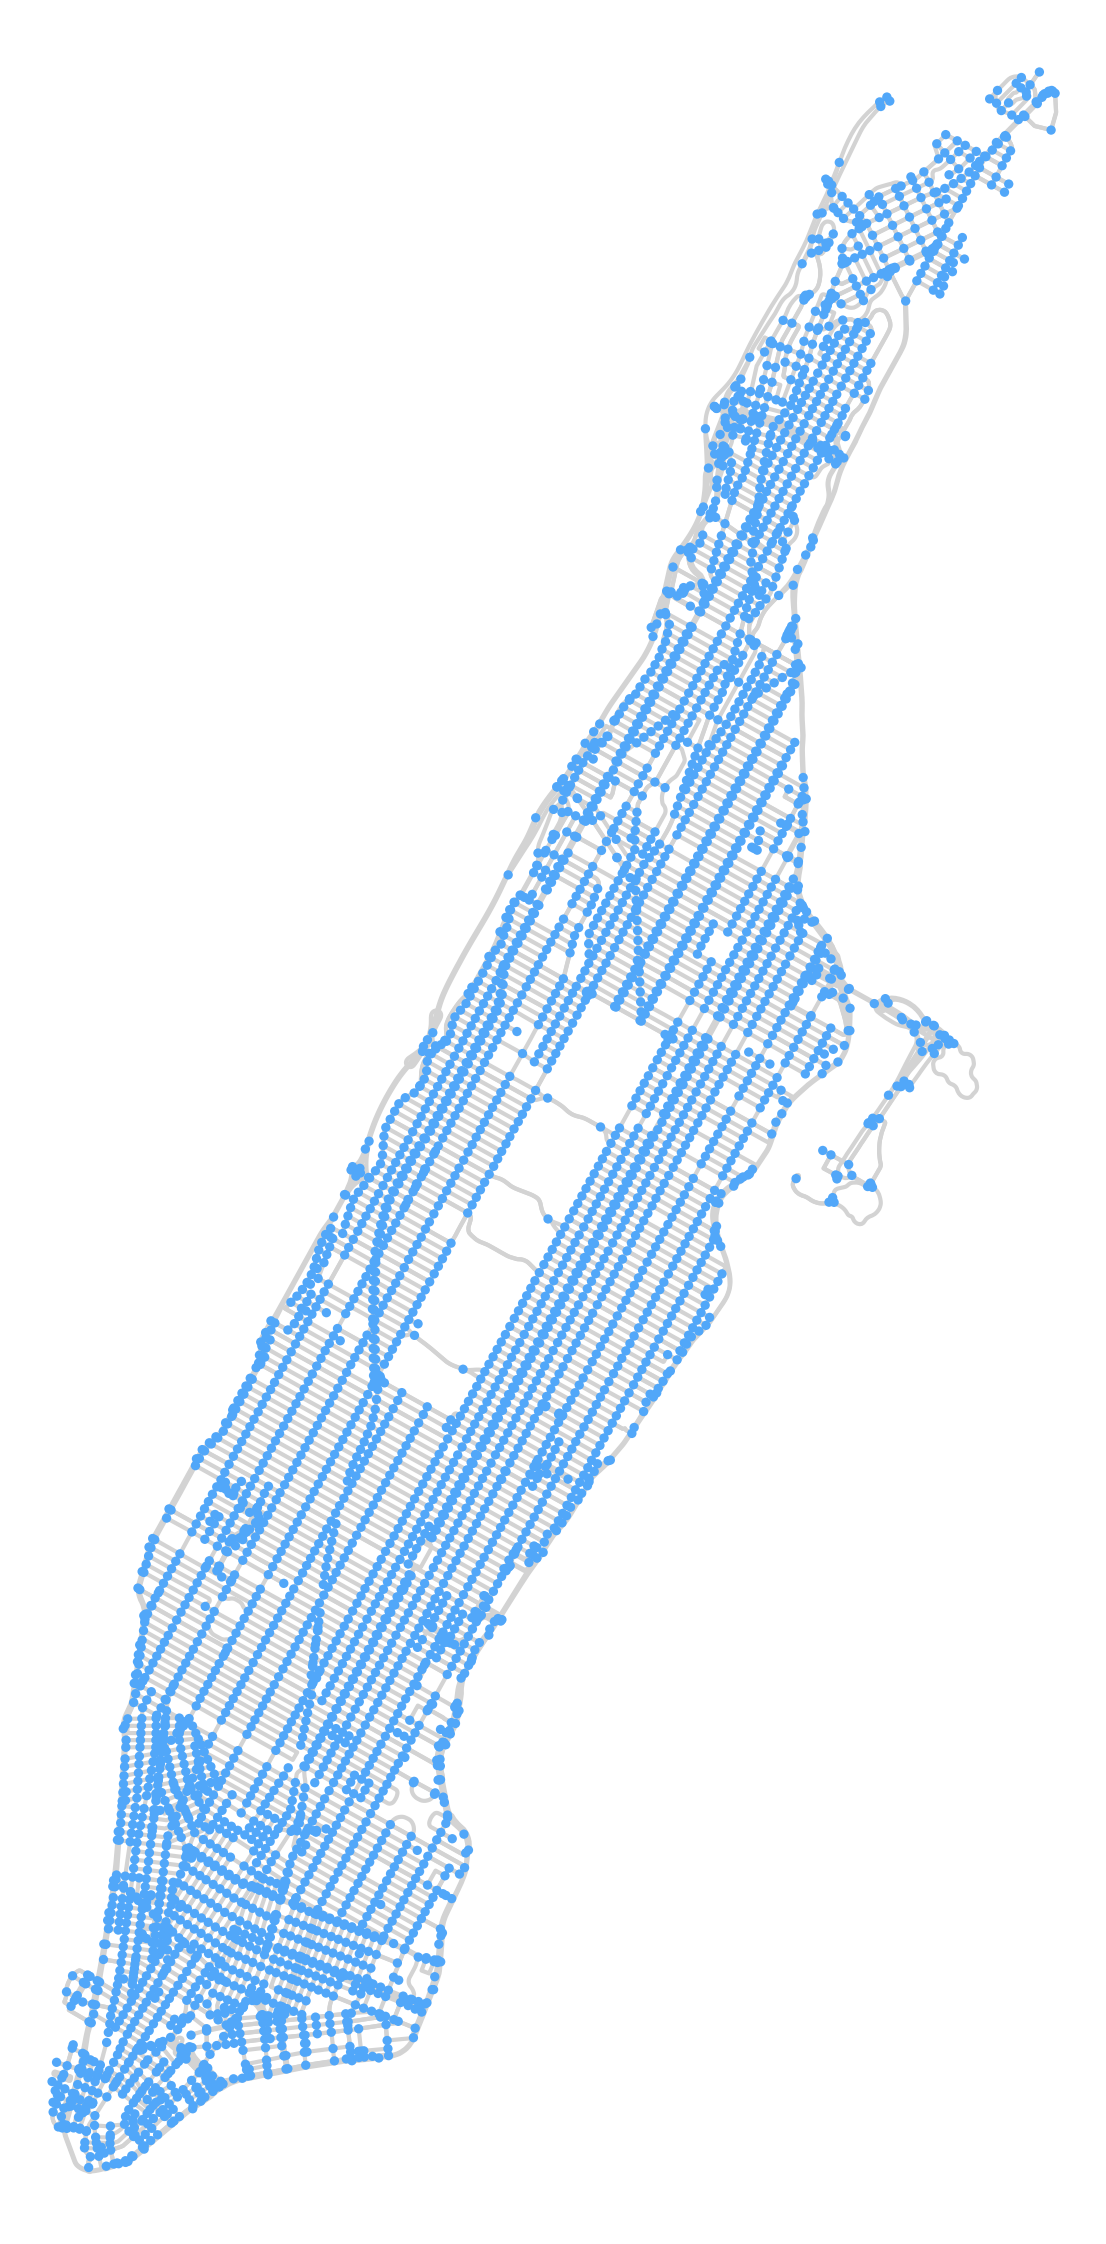

(<Figure size 2400x2400 with 1 Axes>, <AxesSubplot:>)

In [41]:
ox.plot.plot_graph(G_roads, bgcolor='#FFFFFF', node_color=colors[0], edge_color='lightgray', node_size=5)

Each node comes with lat/long coordinates and a couple other features that characterize it

In [42]:
G_roads.nodes[42421728]

{'y': 40.7980478,
 'x': -73.9600437,
 'highway': 'traffic_signals',
 'street_count': 3}

As does each edge

In [43]:
pprint(dict(G_roads[42442575][42437142]))

{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x7f9223009dc0>,
     'highway': 'secondary',
     'length': 86.214,
     'name': 'Amsterdam Avenue',
     'oneway': False,
     'osmid': 732794019}}


Including the distance in meters

In [44]:
coords_1 = (G_roads.nodes[42442575]['y'], G_roads.nodes[42442575]['x'])
coords_2 = (G_roads.nodes[42437142]['y'], G_roads.nodes[42437142]['x'])

geopy.distance.distance(coords_1, coords_2).m

86.17934367646964

We can map an address to a set of GPS coordinates

In [45]:
ox.geocoder.geocode('World Trade Center')

(40.7118877, -74.0124412)

And find the closest node to each set of coordinates

In [46]:
node_i = ox.get_nearest_node(G_roads, ox.geocoder.geocode('World Trade Center'))
node_j = ox.get_nearest_node(G_roads, ox.geocoder.geocode('Columbia University'))

From which we can find the shortest route. By default NetworkX uses Dijkstra's algorithm

In [47]:
route = nx.shortest_path(G_roads, node_i, node_j, weight = 'length')

Which is just a series of nodes

In [48]:
route[:10]

[1431790464,
 42422035,
 42422028,
 42453395,
 42453398,
 42429570,
 42449613,
 42431626,
 42453417,
 4207143418]

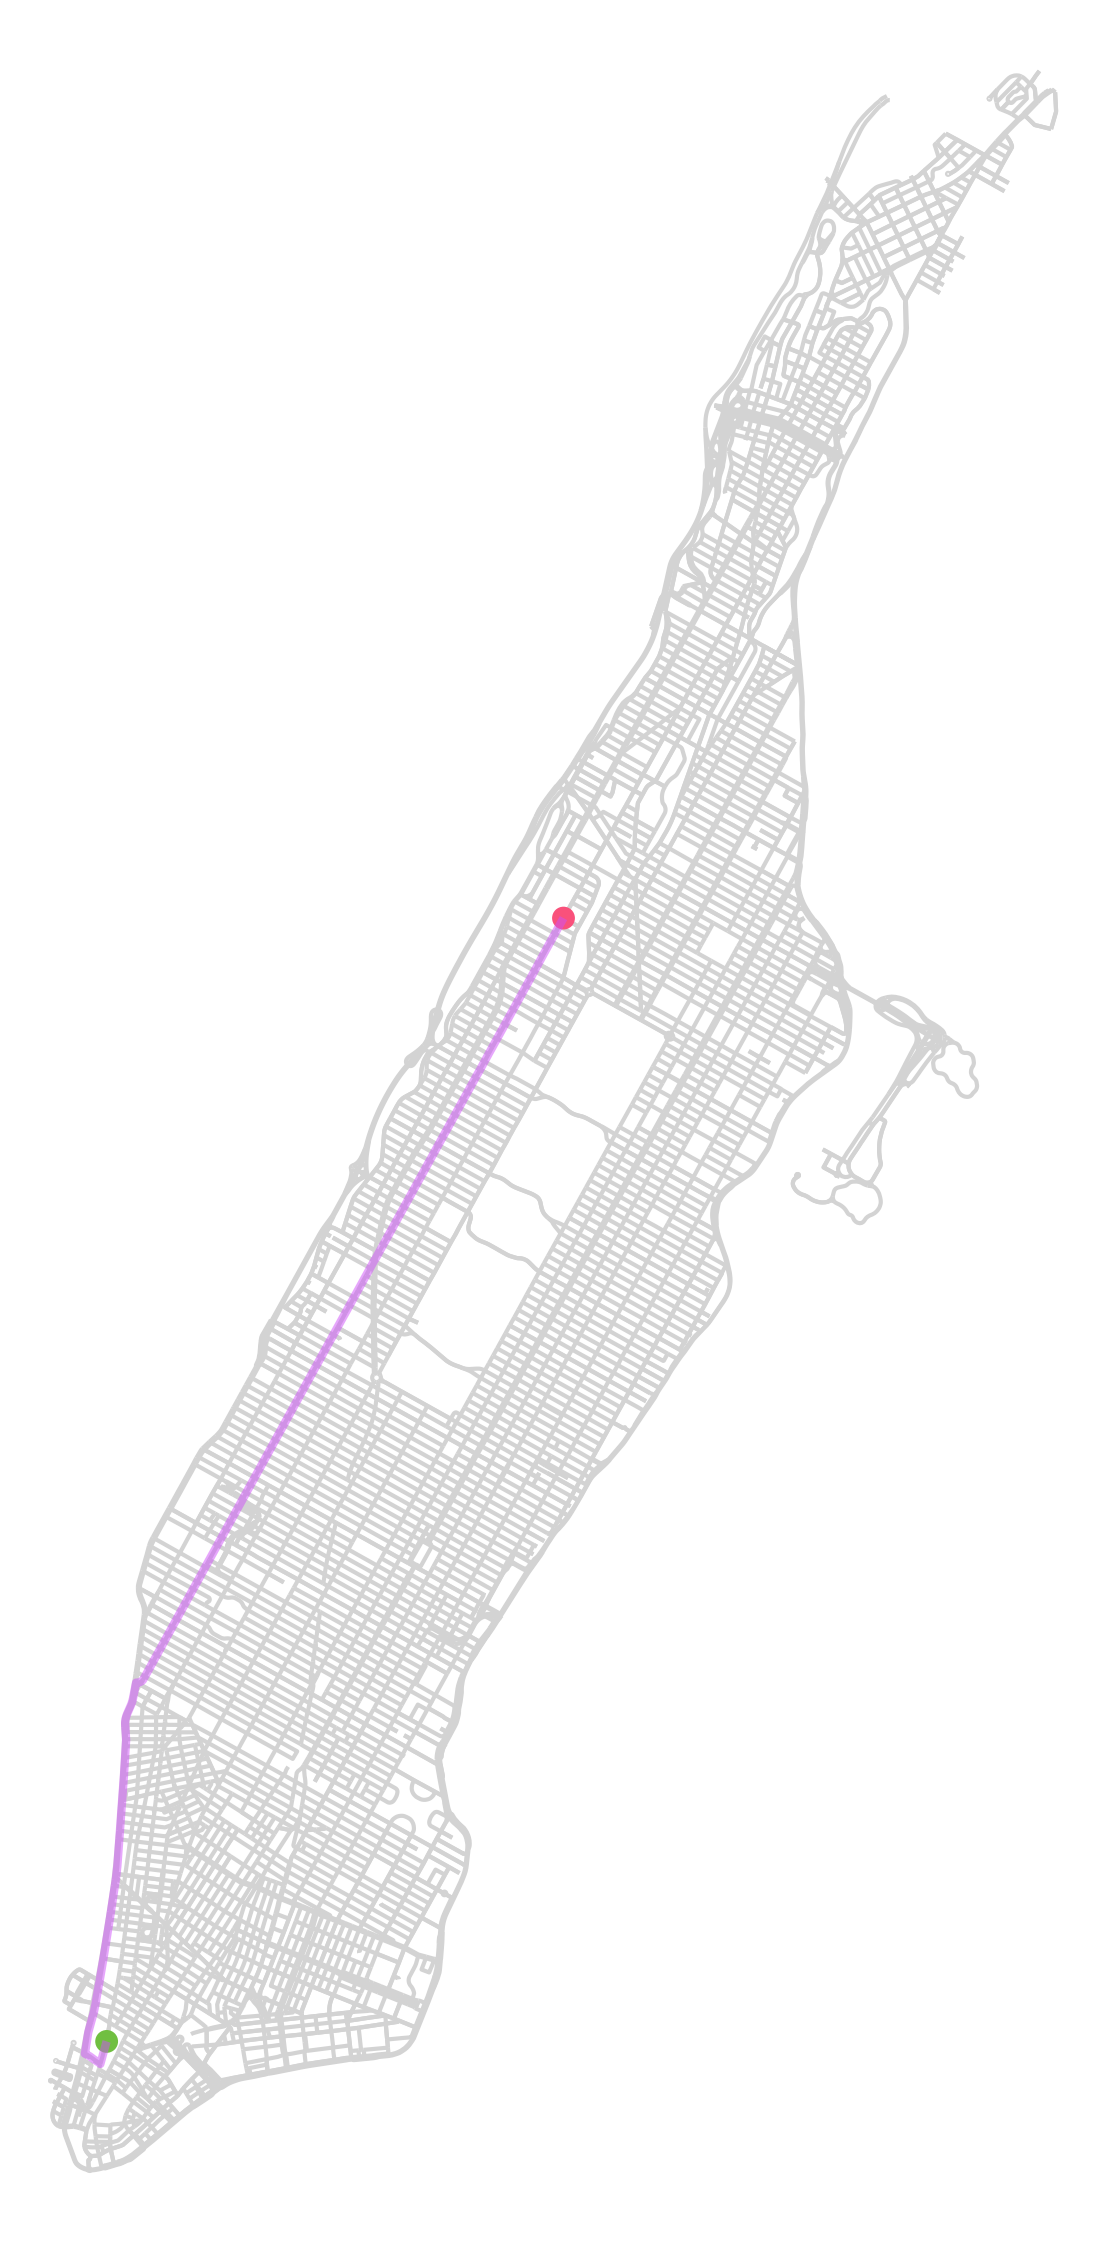

In [49]:
fig, ax = ox.plot.plot_graph_route(G_roads, route, route_alpha=0.5, route_color=colors[1], route_linewidth=2, 
                         node_size=5, bgcolor='#FFFFFF', node_color='none', edge_color='lightgray',
                         orig_dest_size=0, show=False, close=False)

x = (G_roads.nodes[node_i]["x"], G_roads.nodes[node_j]["x"])
y = (G_roads.nodes[node_i]["y"], G_roads.nodes[node_j]["y"])

ax.scatter(x, y, s=30, c=[colors[2], colors[5]], alpha=1, edgecolor="none")

# Directions

In [50]:
ox.bearing.add_edge_bearings(G_roads);

In [51]:
route_edges = list(zip(route[:-1], route[1:]))

In [52]:
G_roads[route_edges[0][0]][route_edges[0][1]][0]

{'osmid': [374423161, 246085471],
 'oneway': True,
 'name': 'Greenwich Street',
 'highway': 'residential',
 'access': 'no',
 'length': 219.90399999999994,
 'geometry': <shapely.geometry.linestring.LineString at 0x7f91d9639e50>,
 'bearing': 195.6}

In [53]:
route_edges

[(1431790464, 42422035),
 (42422035, 42422028),
 (42422028, 42453395),
 (42453395, 42453398),
 (42453398, 42429570),
 (42429570, 42449613),
 (42449613, 42431626),
 (42431626, 42453417),
 (42453417, 4207143418),
 (4207143418, 42436316),
 (42436316, 42440918),
 (42440918, 4207143421),
 (4207143421, 42436024),
 (42436024, 42445174),
 (42445174, 4207143428),
 (4207143428, 42440854),
 (42440854, 42442294),
 (42442294, 42448570),
 (42448570, 42440532),
 (42440532, 42453442),
 (42453442, 591454081),
 (591454081, 42452008),
 (42452008, 42436903),
 (42436903, 42453457),
 (42453457, 42452613),
 (42452613, 42453468),
 (42453468, 42449098),
 (42449098, 42440946),
 (42440946, 42453472),
 (42453472, 42439099),
 (42439099, 246649429),
 (246649429, 402475097),
 (402475097, 4133206254),
 (4133206254, 246648219),
 (246648219, 42445766),
 (42445766, 42449341),
 (42449341, 42439286),
 (42439286, 42429664),
 (42429664, 42454381),
 (42454381, 42427390),
 (42427390, 42443676),
 (42443676, 42434285),
 (424342

In [54]:
directions = []

for node_i, node_j in route_edges:
    for road in G_roads[node_i][node_j].values():
        if 'name' not in road:
            continue
        
        name = road['name']
        length = road['length']
        bearing = road['bearing']
    
        # New Road
        if len(directions) == 0 or name != directions[-1][0]:
            directions.append([name, length, bearing])
            print(directions[-1])
            break
        #Update the same road
        else: 
            directions[-1][1] += length
            directions[-1][2] = bearing
            break

['Greenwich Street', 219.90399999999994, 195.6]
['Liberty Street', 175.076, 303.5]
['West Street', 305.7710000000001, 11.4]
['10th Avenue', 37.599999999999994, 29.9]
['Amsterdam Avenue', 79.023, 29.6]


In [55]:
print("Drive %1.1fm down %s" % (directions[0][1], directions[0][0]))

for i in range(1, len(directions)):
    change = directions[i][2]-directions[i-1][2]
    
    if np.abs(change) < 5:
        msg = 'Continue onto'
    elif change > 0:
        if change > 25: 
            msg = 'Turn right onto'
        else:
            msg = 'Turn slight right onto'
    elif change < 0:
        if change < -25:
            msg = 'Turn left onto'
        else:
            msg = 'Turn slight left onto'
    
    print('%s %s and drive for %1.1fm' % (msg, directions[i][0], directions[i][1]))

print("Arrive at your destination")

Drive 219.9m down Greenwich Street
Turn right onto Liberty Street and drive for 175.1m
Turn left onto West Street and drive for 3528.6m
Turn slight right onto 10th Avenue and drive for 3540.2m
Continue onto Amsterdam Avenue and drive for 4626.0m
Arrive at your destination


<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>